# Person attributes recognition with OpenVINO

This tutorial demonstrates person attributes recognition with MidasNet in OpenVINO. Model information can be found [here](https://docs.openvino.ai/latest/omz_models_model_person_attributes_recognition_crossroad_0230.html)

  ![1](./data/1.png)![2](./data/2.png)

### Description

This model presents a person attributes classification algorithm analysis scenario. It produces probability of person attributions existing on the sample and a position of two point on sample, which can be used for color prob (like, color picker in graphical editors)

In [1]:
model_name = "person-attributes-recognition-crossroad-0230"

## Preparation
### Imports

In [2]:
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import load_image

### Settings

Here set the path of some models, and set the precision of the model used, can choose "FP16" and "FP32", and then import the inference engine here, see if the "GPU" option can be used.

In [3]:
base_model_dir = Path("./model/open_model_zoo_models").expanduser()
omz_cache_dir = Path("./model/open_model_zoo_cache").expanduser()
model_dir = Path("./model").expanduser()
precision = "FP16"

# Check if an iGPU is available on this system to use with Benchmark App
ie = Core()
gpu_available = "GPU" in ie.available_devices

### Dwonload models

Use the omz_downloader tool to download the model. This model is called "person-attributes- recognization-crossroad-0230 ", which is the official model library of Intel OpenVino.

In [4]:
# No need for convert !
path_to_model_weights = Path(
    f"{base_model_dir}/intel/{model_name}/{precision}/{model_name}.bin"
)

if not path_to_model_weights.is_file():
    download_command = f"omz_downloader --name {model_name} --output_dir {base_model_dir} --cache_dir {omz_cache_dir}"
    ! $download_command
else:
    print("Model has been download")

Model has been download


### Load the Model

This step will get the size of the input and output parameters of the model, and you can set the device to run on, such as "CPU","GPU"

In [5]:
ie = Core()
path_to_model = path_to_model_weights.with_suffix(".xml")
print("model path is the model's path")

model = ie.read_model(model=path_to_model)
compiled_model = ie.compile_model(model=model, device_name="CPU")
recognition_output_layer = next(iter(compiled_model.outputs))
recognition_input_layer = next(iter(compiled_model.inputs))

print(f"{recognition_output_layer.shape} is output layer's shape")
print(f"{recognition_input_layer.shape} is input layer's shape")

model path is the model's path
{1, 8, 1, 1} is output layer's shape
{1, 3, 160, 80} is input layer's shape


## Load image

This step loads the image and converts it to the input size

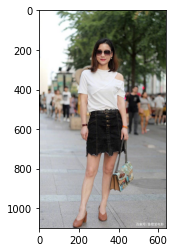

In [6]:
# image_file can point to a URL or local image
image_file = "./data/singer.jpg"

# mark some attributes
attrs = [
    "is_male",
    "has_bag",
    "has_backpack",
    "has_hat",
    "has_longsleeves",
    "has_longpants",
    "has_longhair",
    "has_coat_jacket",
]

image = load_image(image_file)

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = recognition_input_layer.shape

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# set the size of right blank image
attr_image_height = H
attr_image_width = W * 2
attr_image = np.zeros((attr_image_height, attr_image_width, 3), np.uint8)
attr_image[0 : attr_image_height - 1, 0 : attr_image_width - 1] = 255
plt.imshow(output_image);

## Do inference

This step is to use the model to inference, and the attributes of 8 corresponding attribute values will be obtained. If the value is >0.5, the attribute will be considered to be true, otherwise, it is false. The true and false attributes are separated by different colors and then inserted into the image

In [7]:
# use the model to inference
result = compiled_model([input_image])[recognition_output_layer]

# Use different colors to indicate whether the target has the attribute
has_attr = (0, 255, 255)
no_attr = (255, 0, 255)
# attribute text height
text_height = attr_image_height // 10

# there are 8 attributes, put the 8 attributes text into the picture with different color
for index in range(8):
    # print(type(result[0][index]))
    if result[0][index] > 0.5:
        color = has_attr
        # print(f"has attribute {attrs[index]}")
    else:
        color = no_attr
        # print(f"not has attribute {attrs[index]}")
    cv2.putText(
        attr_image,
        text=attrs[index],
        org=(0, text_height * (index + 1)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=(attr_image_height * attr_image_width)
        / 2
        / (attr_image_height * attr_image_width),
        color=color,
        thickness=2,
    )
    # text_height += plus_height

## Show the result picture

This picture shows some attributes of the female singer, with red indicating that the attribute is false and blue indicating that it is true

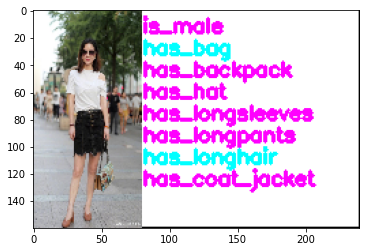

In [8]:
output_image = cv2.resize(output_image, (W, H))
output_image = np.hstack((output_image, attr_image))
plt.imshow(output_image)

# Delete the downloaded model

The purpose of this block is to clear the downloaded Intel model.

When you are done with the above code and no longer need it, you can run the code below

In [9]:
# import shutil
# import os
# # remove model directory
# if os.path.exists(model_dir):
#     shutil.rmtree(model_dir)
# else: